In [1]:
import numpy as np 
import pandas as pd
import os
import glob
import fnmatch
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import ruptures as rpt


In [2]:
from lib.data_classes.pffpFolder import pffpDataFolder
from lib.signal_processing.signal_function import moving_average, find_deriv_change, find_drops
from lib.general_functions.global_constants import GRAVITY_CONST
from lib.general_functions.general_function import convert_time_units


In [3]:
# Testing the binary file classa
#TODO: for some reason I need the full path to read the files, I'll need to look into this in the future
# folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\test"
# folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1" #pffp 3, sequim 2023
# folder_dir = r"/home/sandbiter/Documents/BlueDrop_Analysis_Lib/Potomac_to Jonathan"
# folder_dir = r"/home/sandbiter/Documents/BlueDrop_Analysis_Lib/test_folder"
# folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Clay_Air_Drops_GBE_AdamsPoint"
# folder_dir = r"/home/sandbiter/Documents/BlueDrop_Analysis_Lib/Mouth_1"
# folder_dir = r"/home/sandbiter/Documents/BlueDrop_Analysis_Lib/Clay_Air_Drops_GBE_AdamsPoint"
folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops"
# folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Clay_air_drops\Clay_Air" #1, march 2023
calibration_dir = r"BlueDrop_Calibration_Factors.xlsx"

In [4]:
tip_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\BluedDrop_Cone_Values.xlsx"


In [5]:
# TODO: Combine the pffp_id and the read_calibration_excel_sheet just have the objet call inside
name = "test"
id = 9
test_folder = pffpDataFolder(folder_dir, pffp_id = id, calibration_factor_dir=calibration_dir, survey_name = name)
print(test_folder)

Folder: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops 
Date range: Not set 
PFFP id: 9                 
Calibration Param dir: BlueDrop_Calibration_Factors.xlsx 
Num .bin files: Not set                 
Num files with drops: Not Set


In [6]:
# Read the calibration data
test_folder.read_calibration_excel_sheet()
test_folder.calibration_excel_sheet

# Select the specific calibration params
if id == 3:
    test_folder.get_sensor_calibration_params("Sequim_2021")
elif id == 1:
    test_folder.get_sensor_calibration_params("March_2023")
elif id ==9:
    test_folder.get_sensor_calibration_params("October_2023")
else:
    raise ValueError("not a valid pffp id")



In [7]:
# Init a pffpFile instances for each binary file and store the results in the folder
test_folder.store_pffp_files(recursive = False)

print(test_folder) # Information about the folder

Folder: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops 
Date range: Not set 
PFFP id: 9                 
Calibration Param dir: BlueDrop_Calibration_Factors.xlsx 
Num .bin files: 1                 
Num files with drops: Not Set


In [8]:
# Analyze the selected pffp files
test_folder.analyze_all_files(store_df=True, use_pore_pressure=True, 
                              select_accel=["2g_accel", "50g_accel", "250g_accel"],
                              debug = False)


Folder 'C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops\no_drop_folder' already exists.
Folder 'C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops\funky' already exists.

Progress finding files with drops...
[==================================================] 100.00% ETA (min): 0.0
Initial analysis complete!


In [9]:
print(test_folder)

Folder: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops 
Date range: Not set 
PFFP id: 9                 
Calibration Param dir: BlueDrop_Calibration_Factors.xlsx 
Num .bin files: 1                 
Num files with drops: 1


In [10]:
test_folder.process_drop_files()


Progress processing drops in files...
[==================================================] 100.00% ETA (min): 1.7e-08

In [11]:
file = test_folder.pffp_drop_files[0]
# file.manually_process_drops()

#### Start Bearing Capcity Analysis

In [12]:
drop = file.drops[0]
pffp_id = test_folder.pffp_id
drop.get_pffp_tip_values(pffp_id=pffp_id, tip_type="cone", date_string = "April_2024", file_dir = tip_dir)

In [13]:
drop.water_drop = True
drop.convert_tip_vals()

for name in ["projected", "mantle"]:
    drop.calc_drop_contact_area(area_type = name)
    drop.calc_drop_dynamic_bearing()
    drop.calc_drop_qs_bearing(k_factor = 0.3)

c:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\lib\mechanics_functions\bearing_capacity_funcs.py:121: RuntimeWarning: invalid value encountered in log10
  log_val = np.log10(velocity/ref_velocity)
c:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\lib\mechanics_functions\bearing_capacity_funcs.py:121: RuntimeWarning: invalid value encountered in log10
  log_val = np.log10(velocity/ref_velocity)


In [14]:
drop.bearing_df.columns

Index(['contact_area_projected', 'qDyn_projected', 'qsbc_proj_0.3',
       'contact_area_mantle', 'qDyn_mantle', 'qsbc_mant_0.3'],
      dtype='object')

s


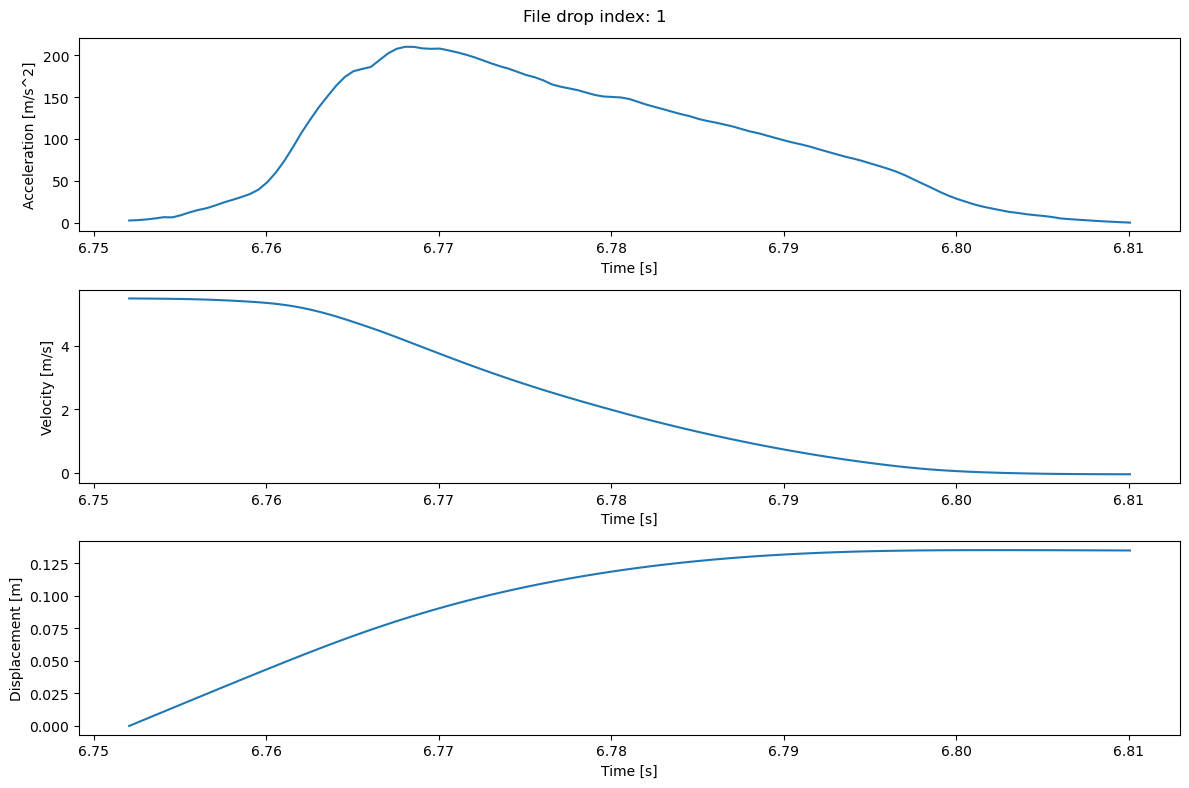

In [15]:
drop.quick_view_impulse(interactive = False)

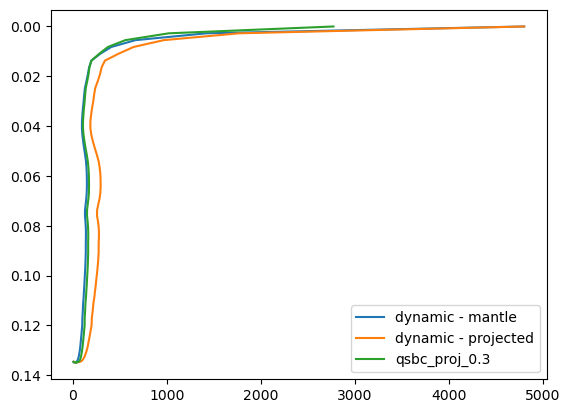

In [16]:
plt.plot(drop.bearing_df["qDyn_mantle"]/1000, drop.impulse_df["displacement"], label = "dynamic - mantle")
plt.plot(drop.bearing_df["qDyn_projected"]/1000, drop.impulse_df["displacement"], label = "dynamic - projected")

# plt.plot(drop.bearing_df["qsbc_mant_0.3"]/1000, drop.impulse_df["displacement"], label = "qsbc_mant_0.3")

plt.plot(drop.bearing_df["qsbc_proj_0.3"]/1000, drop.impulse_df["displacement"], label = "qsbc_proj_0.3")
plt.plot()
plt.gca().invert_yaxis()
plt.legend()

In [17]:
drop.impulse_df

,Time,accel,velocity,displacement
13504,6.752056,2.874409,5.488787,-0.000000
13505,6.752556,3.313948,5.487240,0.002744
13506,6.753056,4.141096,5.485376,0.005487
13507,6.753556,5.322576,5.483010,0.008229
13508,6.754056,6.803618,5.479978,0.010970
...,...,...,...,...
13616,6.808057,2.432053,-0.046764,0.134713
13617,6.808557,1.847988,-0.047834,0.134690
13618,6.809057,1.301546,-0.048621,0.134665
13619,6.809557,0.802392,-0.049147,0.134641


In [18]:
# drop.quick_view_release()

In [19]:
# drop.quick_view_impulse()

In [20]:
# file.quick_view(interactive=True)

In [21]:
print(file)

File Directory: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops\foo0C25.bin 
Num Drops in file: 2         
Drop Date: 2024-04-24 
Drop Time: 20:00:55.058396         
df stored: True        
Concat accel stored: True


In [22]:
print(drop)

----- Drop Info ----- 
Containing file: foo0C25.bin 
File Drop Index: 1 
Water Drop: True            
Drop indices: {'release_index': 8730, 'start_impulse_index': 13504, 'end_impulse_index': 13621} 
Processed: True 
Manually Processed: False


In [23]:
drop.output_impulse_data(folder_dir = "stark_drops\processed_data")
drop.output_release_data(folder_dir = "stark_drops\processed_data")
drop.output_bearing_data(folder_dir = "stark_drops\processed_data")

In [33]:
from datetime import datetime

# Get the current date and time
current_date_time = datetime.now()

# Extract the month, day, and year
current_month = current_date_time.month
current_day = current_date_time.day
current_year = str(current_date_time.year)[2:]

survey_name = test_folder.survey_name
survey_id = "{}_YR{}{}{}".format(survey_name, current_year, current_month, current_day)
print(survey_id)
file.new_pffp_file_name(survey_id=survey_id)

test_YR24429


In [34]:
print(file)

File Directory: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops\test_YR24429_0C25.bin 
Num Drops in file: 2         
Drop Date: 2024-04-24 
Drop Time: 20:00:55.058396         
df stored: True        
Concat accel stored: True


### Things that need to be done
* Make a new filename for all of the files based on the survey
  * Will need to update the containing file information for the drops
  
* Trim the top of the bearing data plot (doesn't make a lot of sense but sure)
* Save regular acceleration data plot
* Save bearing data plot
* Meet back with Rahi and integrate the ML funciton into the code
  
* Create the a test database that has:
  * base_data
  * accel_data
  
* Add on the following tables
  * bearing_capacity
  
* Add on the followinig tables
  * bluedrop config
  * bluedrop calibration data



### Options for formattig data
* Use a JSON for a quickoverview of the survey metadata
* Use a csv format to store information about each of the drops